In [1]:
import geopandas as gpd
import pandas as pd
import ee
ee.Initialize()

In [5]:
gdf = gpd.read_file("data/0_shp/unique_stations_no_repeated.shp")
len(gdf)

2002

In [3]:
table = ee.FeatureCollection("users/dfgm2006/FAO/unique_stations_indonesia")

# Import the Landsat 8 TOA image collection.
l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA');

point = table.filter(ee.Filter.eq("id", "BRG_150710_03")).first()
point = ee.Feature(point).buffer(30).geometry().bounds()


ic = ee.ImageCollection(
  l8.filterBounds(table)
    .filterDate('2020-01-01', '2020-06-30')
);

def get_ndvi(image):
  # Compute the Normalized Difference Vegetation Index (NDVI).
  nir = image.select('B5');
  red = image.select('B4');
  return nir.subtract(red).divide(nir.add(red)).rename('NDVI');
  
ndvi = ic.map(get_ndvi).reduce(ee.Reducer.mean())


result_0 = ee.Image(ndvi).reduceRegion(**{
  "reducer" : ee.Reducer.mean(),
  "geometry" : point,
  "scale" : 30
})

result = ee.Image(ndvi).reduceRegions(**{
    "collection": table,  
    "reducer": ee.Reducer.mean(),
    "scale": 30
}).getInfo()

In [4]:
avg_ndvi = pd.DataFrame([(feature["properties"]["id"], feature["properties"]["mean"]) for feature in result["features"]])
avg_ndvi.columns = ["id", "ndvi"]

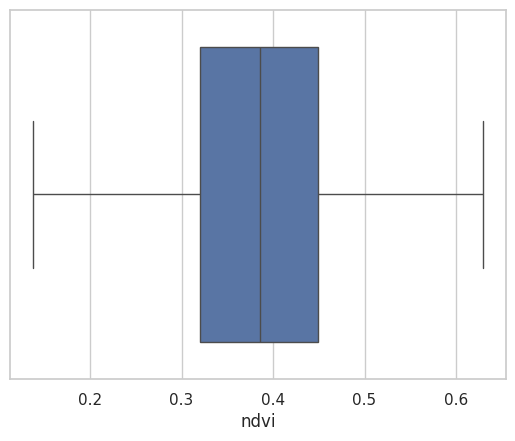

In [5]:
# plot boxplot of ndvi
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=avg_ndvi["ndvi"])
plt.show()

In [7]:
# describe the ndvi
avg_ndvi["ndvi"].describe()

count    2002.000000
mean        0.384861
std         0.092269
min         0.137151
25%         0.319824
50%         0.386196
75%         0.449266
max         0.629946
Name: ndvi, dtype: float64

In [8]:
avg_ndvi[avg_ndvi.ndvi <= 0.386196]

,id,ndvi
3,15_RAPP_TP-VI-8,0.326582
4,15_RAPP_TP-XII-3a,0.379156
6,15_RAPP_TP-XIII-61,0.270214
7,15_RAPP_TP-XII-32b,0.321629
8,15_RAPP_PPDVI-11a,0.313400
...,...,...
1995,32_BAP_ASH1010,0.362954
1996,32_BAP_SJO6050,0.340956
1999,10_MTI_MTI_J135_P1,0.361369
2000,32_BAP_BRF3120,0.320919


In [10]:
# Export ids of stations with ndvi <= 0.386196
avg_ndvi[avg_ndvi.ndvi <= 0.386196]["id"].to_csv("data/ids_low_ndvi.csv", index=False)

## FIlter stations by correlation

In [2]:
import pandas as pd
import geopandas as gpd

In [6]:
df = pd.read_csv("data/field_data_all.csv")


,source,id,lon,lat,date,gwl_cm
0,ach,BRG_140301_01,102.099167,1.519444,2018-10-15,-14.4
1,ach,BRG_140301_01,102.099167,1.519444,2018-10-16,-17.9
2,ach,BRG_140301_01,102.099167,1.519444,2018-10-17,-20.6
3,ach,BRG_140301_01,102.099167,1.519444,2018-10-18,-18.1
4,ach,BRG_140301_01,102.099167,1.519444,2018-10-19,-23.1
...,...,...,...,...,...,...
244187,wal,138_NBR_M13,135.275777,-3.407239,2023-05-26,-45.0
244188,wal,138_NBR_M13,135.275777,-3.407239,2023-06-13,-14.0
244189,wal,138_NBR_M13,135.275777,-3.407239,2023-06-26,-30.0
244190,wal,138_NBR_M13,135.275777,-3.407239,2023-07-15,-27.0
